## Implementing CPPI and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import analysis_kit as ak

In [2]:
# Load the industry returns and total market index that we previously created

ind_return=ak.get_ind_returns()
tmi_return=ak.get_total_market_index_returns()

In [3]:
# Selecting industries as our test data for risky asset

risky_r=ind_return["2000":][["Steel","Fin","Beer"]] 

In [4]:
risky_r.shape

(228, 3)

In [5]:
# safe asstets

safe_r=pd.DataFrame().reindex_like(risky_r) # reindex_like simply mimics and recreates the dimensions of the provided df 

In [6]:
# We are gonna assume that for all the 228 periods, the rf asset will return annually 3%. Hence, we have to convert this to a 
# monthly figure

safe_r[:]=0.03/12
start=1000 # Starting dollar amount
floor= 0.8 # floor of 80% of the starting value


### STEPS 

1. Cushion= Asset value - Floor value

2. Compute an allocation to safe and risky asset ----> M * Risk Budget

3. Recompute the asset value based on the returns 

#### CPPI Algo

dates=risky_r.index # dates are needed coz we are gonna ask the algo to reiterate over a bunch of dates

n_steps=len(dates) # Simply the number of monthly periodic dates. Since our data is monthly data, its just total no. of months

account_value=start # we have to know what is our account value at any point in time t 

floor_value= start * floor # multiplication because the floor was earlier set as a percentage figure

m= 3

# This part is not actually "needed" for the CPPI algo but it is really good for us to observe as we run the algo
# Since cppi is essentially a backtest, at each stage of the backtest

account_history= pd.DataFrame().reindex_like(risky_r)
cushion_history= pd.DataFrame().reindex_like(risky_r)
risky_w_history= pd.DataFrame().reindex_like(risky_r)

# Core of the CPPI Algo: the for loop

for step in range(n_steps): # the "step" here refers to an arbitrary variable filled for the loop to run. In our case, it refers
                            # to the no. of rows in the n_steps. 
                            # range(n_steps) simply means the body of the loop is gonna be executed first with step=1, then 
                            # step=2 and all the way to n_steps (not including the n_step)
    
    cushion=(account_value-floor_value)/account_value

    risky_w= m * cushion
    
    risky_w= np.minimum(risky_w, 1) # This means the min weight of risky asset is the lower of whatever we got as risky_w and 1
    
    risky_w= np.maximum(risky_w, 0) # Means the max weight of risky asset is the higher of whatever we got as risky_w and 0
    
    safe_w= 1-risky_w # This is pretty intuitive
    
    risky_alloc= account_value * risky_w
    
    safe_alloc= account_value * safe_w
    
    ## update the account value for a each time step. Account value, as you can see, is just combination of risky and rf assets
    
    account_value= (risky_alloc * (1+risky_r.iloc[step])) + (safe_alloc * (1+safe_r.iloc[step]))
    
    ## save the values so that I can see at the history and plot it
    
    account_history.iloc[step]=account_value
    cushion_history.iloc[step]=cushion
    risky_w_history.iloc[step]=risky_w
    

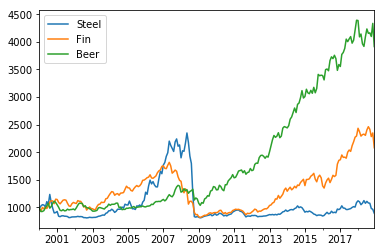

In [8]:
account_history.plot()

#### Below is what I would get if I had done none of the CPPI and just invested all the 1000 dollars in the risky asset

In [9]:
risky_wealth= start * (1+risky_r).cumprod()

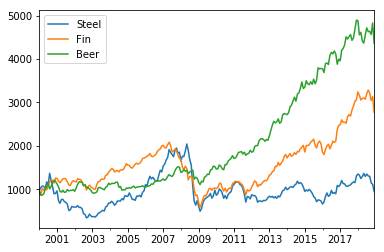

In [10]:
risky_wealth.plot()

#### Now, lets pick an industry as risky asset and compare its generated wealth to the returns of cppi

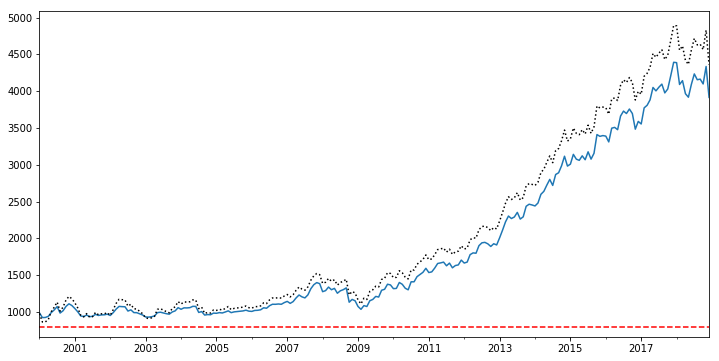

In [11]:
ax=account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r",linestyle="--")

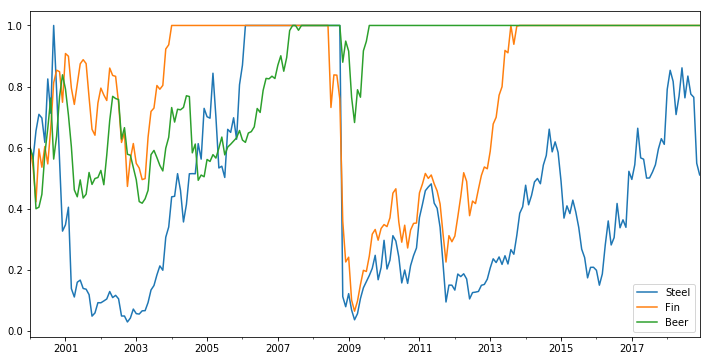

In [12]:
risky_w_history.plot(figsize=(12,6))

#### Lets try the Finance industry

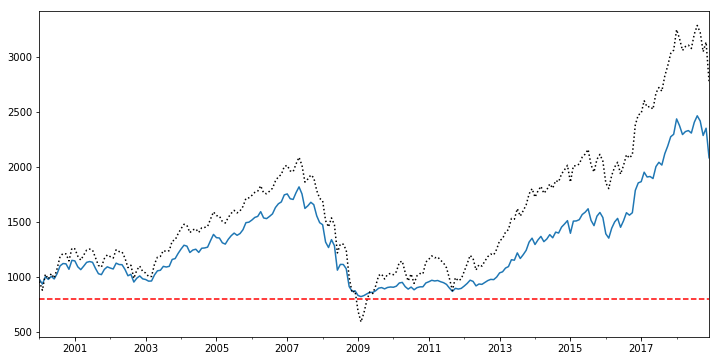

In [13]:
ind="Fin"
ax=account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r",linestyle="--")

In [14]:
%autoreload 2

#### This is the performance of risky assets without using CPPI

In [16]:
ak.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Steel,-0.002790,0.312368,-0.326334,4.144381,-0.758017,-0.102567,0.150139,0.208117
Fin,0.055166,0.192909,-0.533218,4.995534,-0.718465,0.126718,0.091224,0.132175
Beer,0.080598,0.138925,-0.493545,4.173881,-0.271368,0.354314,0.063015,0.091442


#### With CPPI

In [17]:
btr=ak.run_cppi(risky_r)
ak.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Steel,-0.005167,0.174180,-1.995143,17.110190,-0.655198,-0.196750,0.091995,0.130153
Fin,0.040894,0.131678,-0.946504,6.051414,-0.549673,0.080352,0.065535,0.091621
Beer,0.075544,0.115462,-0.669250,4.760879,-0.259582,0.383772,0.052923,0.074908


### Lets try on the total market index returns

#### Without CPPI

In [18]:
tmi_return=pd.DataFrame(tmi_return)

In [19]:
tmi_return.columns=["Returns"]

In [20]:
tmi_return.head()

,Returns
1926-07,0.031375
1926-08,0.028957
1926-09,0.005566
1926-10,-0.028504
1926-11,0.028039


In [21]:
ak.summary_stats(tmi_return["2007":])

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Returns,0.074522,0.149973,-0.742423,4.556138,-0.499943,0.288744,0.071312,0.096315


#### WITH CPPI

In [23]:
btr=ak.run_cppi(tmi_return["2007":])
ak.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Returns,0.069416,0.100381,-0.588292,3.740932,-0.229683,0.382052,0.045678,0.062953


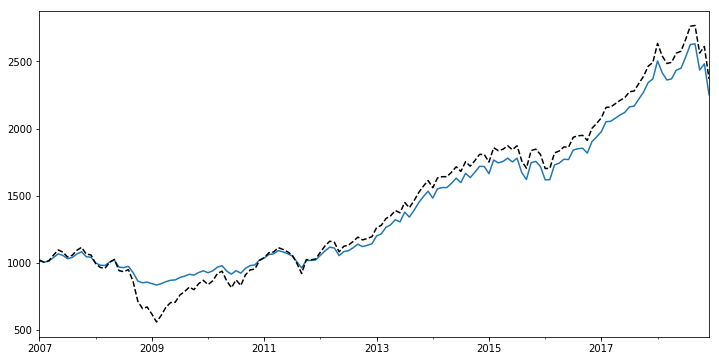

In [24]:
# Plotting the two strategies

ax=btr["Wealth"].plot(figsize=(12,6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [25]:
# Summary for the total market index

ak.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Returns,0.069416,0.100381,-0.588292,3.740932,-0.229683,0.382052,0.045678,0.062953


In [29]:
# Summary for cppi strategy

ak.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Max Drawdown,Sharpe Ratio,Cornish-Fisher VaR (5%),Historic VaR (5%)
Returns,0.073411,0.150463,-0.734939,4.523488,-0.499943,0.280618,0.071592,0.096315
